In [10]:
import os, json
import numpy as np
from os.path import dirname
from pandas import DataFrame, concat
from tqdm import tqdm
import matplotlib.pyplot as plt


In [11]:
from glob import glob
# adjust path to where the data is  
acq_ext_files = glob('../data/data_jun_26/s*_scream_acq_ext_*[0-9].json')
rec_files = glob('../data/data_jun_26/s*_scream_recovery_*[0-9].json')

In [61]:

## Preallocate space.
DATA_ACQEXT = []

for file in tqdm(acq_ext_files):

    ## Load file.
    subject = file[21:24]

    with open(file, 'r') as f:
        JSON = json.load(f)

    
    data_to_pd = []
    for dd in JSON:
        if (dd['trial_type'] == 'fctask-trial') or (dd['trial_type']=='expectancy-rating'):
            data_to_pd.append(dd)
    
    data = DataFrame(data_to_pd)

    data['fc_rt'] = np.round(data.fc_rt * 1e-3, 3)
    data['fc_key'] = data['fc_key'].replace({32.0:1})
    data['time_elapsed'] = np.round(data.time_elapsed * 1e-3, 3)

    data['csMinusRating'] = data['csMinusRating'].astype(float)
    data['csPlusRating'] = data['csPlusRating'].astype(float)

    data['totalTime'] = np.round(data.totalTime * 1e-3, 3)

    # update phases
    phases = ['practice', 'acquisitionBlockOne', 'acquisitionBlockTwo', 'extinctionBlockOne', 'extinctionBlockTwo', 'extinctionBlockThree']

    data['exp_phase']='a'
    phases_for_expectacy = {phase:0 for phase in phases}
    for phase in phases:
        # print(phase)
        # print(np.where(data['fc_phase']==phase)[0][0])

        phases_for_expectacy[phase] = np.where(data['fc_phase']==phase)[0][0]

    for i, row in data.iterrows():
        for phase in phases:
            if row['trial_index'] >= phases_for_expectacy[phase]:
                data.at[i,'exp_phase'] = phase


    data['csMinusRating'] = np.where(data.csMinusRating.isna(), data.csRating , data.csMinusRating)
    data['csMinusRTs'] = np.where(data.csMinusRTs.isna(), data.csRTs , data.csMinusRTs)

    data['csMinusRTs'] = data.csMinusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 
    data['csPlusRTs'] = data.csPlusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 
    data['csRTs'] = data.csPlusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 

    data['csPlusRTs'] = np.round(data.csPlusRTs * 1e-3, 3) 
    data['csMinusRTs'] = np.round(data.csMinusRTs * 1e-3, 3) 
    data['csRTs'] = np.round(data.csRTs * 1e-3, 3) 


    data['er_trial'] = np.nan
    data['practice'] = False

    trial_count = 0
    for r, row in data.iterrows():
        if row['trial_type']=='expectancy-rating':
            if row['sequence']==['CS']:
                data.at[r,'practice'] = True
            else:
                data.at[r,'er_trial'] = trial_count
                trial_count+=1



    data.insert(0,'subject',subject)

    DATA_ACQEXT.append(data)

DATA_ACQEXT = concat(DATA_ACQEXT).sort_values(['subject','trial_index'])
DATA_ACQEXT = DATA_ACQEXT.reset_index()

DATA_ACQEXT['phase'] = DATA_ACQEXT.exp_phase.map(lambda x: x[:3])
DATA_ACQEXT.er_trial= DATA_ACQEXT.er_trial.astype('int')

100%|██████████| 5/5 [00:00<00:00, 26.78it/s]


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
DATA_ACQEXT

,index,subject,stimulus_image,stimulus_audio,endTime,fc_rt,fc_key,timeout,fc_phase,fc_trial,...,csPlusRating,csMinusRating,csPlusResponses,csPlusRTs,csMinusResponses,csMinusRTs,exp_phase,er_trial,practice,phase
0,0,100,../static/fctask_shared/images/fctask-shared/c...,None,188454.7,2.634,1.0,0,practice,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,practice,NaN,False,pra
1,1,100,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,200.335,practice,NaN,True,pra
2,2,100,../static/fctask_shared/images/fctask-shared/c...,None,203470.6,1.592,1.0,0,practice,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,practice,NaN,False,pra
3,3,100,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210.551,practice,NaN,True,pra
4,4,100,../static/fctask_shared/images/fctask-shared/c...,../static/fctask_shared/audio/fctask-shared/ne...,219944.3,3.045,1.0,0,practice,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,practice,NaN,False,pra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,83,106,../static/fctask_shared/images/fctask-shared/c...,None,984272.4,3.168,1.0,0,extinctionBlockThree,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,extinctionBlockThree,NaN,False,ext
436,84,106,../static/fctask_shared/images/fctask-shared/m...,None,988328.5,1.136,1.0,0,extinctionBlockThree,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,extinctionBlockThree,NaN,False,ext
437,85,106,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,"[43, 51]",999.936,"[4, 88]",995.208,extinctionBlockThree,19.0,False,ext
438,86,106,../static/fctask_shared/images/fctask-shared/m...,None,1012912.3,10.264,1.0,1,extinctionBlockThree,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,extinctionBlockThree,NaN,False,ext


In [ ]:
import seaborn as sns

In [59]:
DATA_ACQEXT.columns

Index(['index', 'subject', 'stimulus_image', 'stimulus_audio', 'endTime',
       'fc_rt', 'fc_key', 'timeout', 'fc_phase', 'fc_trial', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'task',
       'task_version', 'sub', 'timestamp', 'fout', 'sequence', 'csRating',
       'totalTime', 'csResponses', 'csRTs', 'csPlusRating', 'csMinusRating',
       'csPlusResponses', 'csPlusRTs', 'csMinusResponses', 'csMinusRTs',
       'exp_phase', 'er_trial', 'practice', 'phase'],
      dtype='object')

In [66]:
DATA_ACQEXT[DATA_ACQEXT.er_trial>=0][['trial_index','subject','sequence','csMinusRating', 'csPlusRating','er_trial', 'phase']]

,trial_index,subject,sequence,csMinusRating,csPlusRating,er_trial,phase
12,24,100,"[CS+, CS-]",NaN,NaN,0.0,acq
17,30,100,"[CS-, CS+]",19.0,63.0,1.0,acq
21,35,100,"[CS+, CS-]",21.0,70.0,2.0,acq
25,40,100,"[CS-, CS+]",NaN,NaN,3.0,acq
28,44,100,"[CS+, CS-]",28.0,71.0,4.0,acq
...,...,...,...,...,...,...,...
421,107,106,"[CS+, CS-]",NaN,NaN,15.0,ext
424,111,106,"[CS-, CS+]",NaN,NaN,16.0,ext
431,123,106,"[CS+, CS-]",NaN,NaN,17.0,ext
434,127,106,"[CS+, CS-]",NaN,NaN,18.0,ext


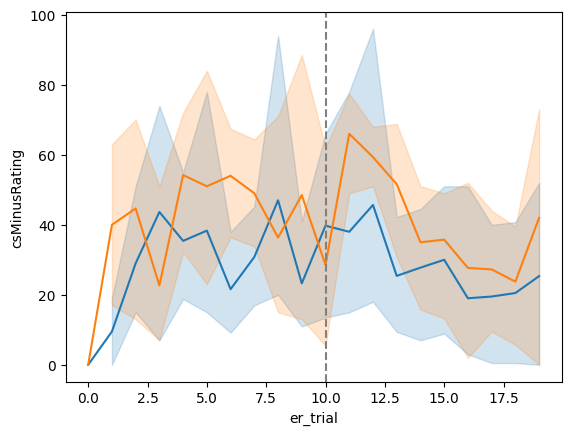

In [76]:
sns.lineplot(data = DATA_ACQEXT[DATA_ACQEXT.er_trial>=0],x='er_trial',y='csMinusRating')#, hue='phase')
sns.lineplot(data = DATA_ACQEXT[DATA_ACQEXT.er_trial>=0],x='er_trial',y='csPlusRating')#, hue='phase')
plt.axvline(x=10, color='grey', linestyle='--')

In [329]:
# data[['fc_phase', 'trial_index']]

In [77]:
/

()

In [387]:
# np.where(data['fc_phase']=='acquisitionBlockOne')[0][0]

<AxesSubplot: xlabel='trial_index', ylabel='fc_phase'>

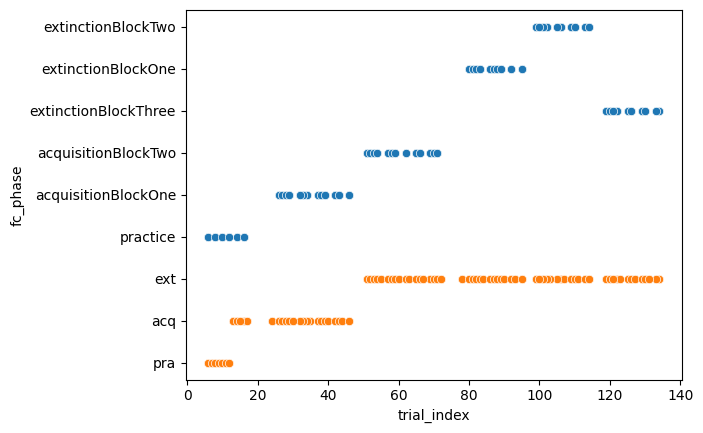

In [398]:
# DATA_ACQEXT[['subject', 'exp_phase','phase']]

sns.scatterplot(data=DATA_ACQEXT,x='trial_index', y='fc_phase')
# sns.scatterplot(data=DATA_ACQEXT,x='trial_index', y='trial_type')
sns.scatterplot(data=DATA_ACQEXT,x='trial_index', y='phase')


In [79]:

## Preallocate space.
DATA_REC = []

for file in tqdm(rec_files):

    ## Load file.
    subject = file[21:24]

    with open(file, 'r') as f:
        JSON = json.load(f)

    
    data_to_pd = []
    for dd in JSON:
        if (dd['trial_type'] == 'fctask-trial') or (dd['trial_type']=='expectancy-rating'):
            data_to_pd.append(dd)
    
    data = DataFrame(data_to_pd)

    # data['fc_rt'] = np.round(data.fc_rt * 1e-3, 3)
    data['fc_key'] = data['fc_key'].replace({32.0:1})
    data['time_elapsed'] = np.round(data.time_elapsed * 1e-3, 3)

    data['csMinusRating'] = data['csMinusRating'].astype(float)
    data['csPlusRating'] = data['csPlusRating'].astype(float)

    data['totalTime'] = np.round(data.totalTime * 1e-3, 3)

    # update phases
    # phases = ['practice', 'acquisitionBlockOne', 'acquisitionBlockTwo', 'extinctionBlockOne', 'extinctionBlockTwo', 'extinctionBlockThree']
    # abs_phases = ['n/a', 'acquisition', 'acquisition', 'extinction', 'extinction', 'extinction']

    # data['exp_phase']='a'
    # data['phase']='a'
    # phases_for_expectacy = {phase:0 for phase in phases}
    # for phase in phases:
    #     # print(phase)
    #     # print(np.where(data['fc_phase']==phase)[0][0])

    #     phases_for_expectacy[phase] = np.where(data['fc_phase']==phase)[0][0]

    # for i, row in data.iterrows():
    #     for phase, abs_phase in zip(phases, abs_phases):
    #         if row['trial_index'] >= phases_for_expectacy[phase]:
    #             data.at[i,'exp_phase'] = phase
    #             data.at[i,'phase'] = abs_phase


    data['csMinusRTs'] = data.csMinusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 
    data['csPlusRTs'] = data.csPlusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 
    data['csRTs'] = data.csPlusRTs.map(lambda x: x[0] if (type(x)==type([]) and len(x)>0) else np.nan) 

    data['csPlusRTs'] = np.round(data.csPlusRTs * 1e-3, 3) 
    data['csMinusRTs'] = np.round(data.csMinusRTs * 1e-3, 3) 
    data['csRTs'] = np.round(data.csRTs * 1e-3, 3) 
    
    data.insert(0,'subject',subject)

    data['er_trial'] = np.nan
    trial_count = 0
    for r, row in data.iterrows():
        if row['trial_type']=='expectancy-rating':
            data.at[r,'er_trial'] = trial_count
            trial_count+=1



    DATA_REC.append(data)

DATA_REC = concat(DATA_REC).sort_values(['subject','trial_index'])
DATA_REC = DATA_REC.reset_index()



100%|██████████| 5/5 [00:00<00:00, 56.97it/s]


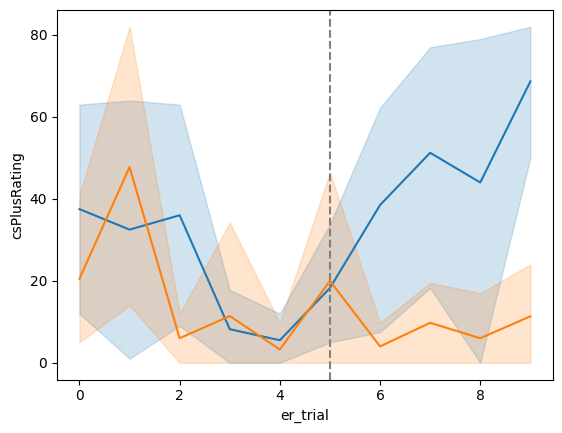

In [81]:
sns.lineplot(data = DATA_REC,x='er_trial',y='csPlusRating')#, hue='phase')
sns.lineplot(data = DATA_REC,x='er_trial',y='csMinusRating')#, hue='phase')
plt.axvline(x=5, color='grey', linestyle='--')

In [111]:
DATA_ACQEXT.er_trial.dropna().max()

19.0

### EXPECTED expectacy rates

1
---
acq:
4 of 13 trials
5 of 13 trials
---
1
---
ext:
3 of 10
3 of 10
3 of 10

--- 

1
---
rec:
2 of 8
2 of 8
---
1
---
rel:
3 of 8
3 of 8




1+9+1+9 // 1+4+1+6


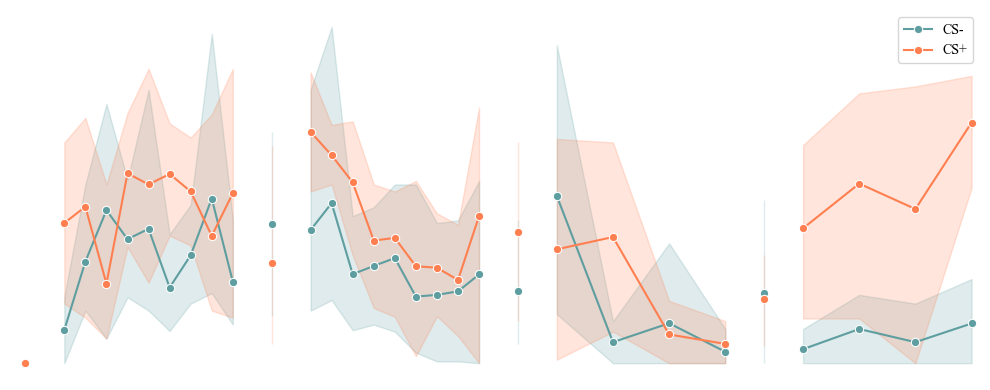

In [137]:
fig, ax = plt.subplots(1,8, figsize=(10,4), width_ratios=[1, 6,1,6,1,6,1,6], sharey=True)


# pre acq
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial==0)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[0], legend=False)
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial==0)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[0], legend=False)
#  acq
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial>0) & (DATA_ACQEXT.er_trial<=9)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[1], legend=False)
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial>0) & (DATA_ACQEXT.er_trial<=9)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[1], legend=False)

#  between acq and ext
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial==10)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[2], legend=False)
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial==10)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[2], legend=False)

#ext

sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial>10) & (DATA_ACQEXT.er_trial<=19)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[3], legend=False)
sns.lineplot(data = DATA_ACQEXT[(DATA_ACQEXT.er_trial>10) & (DATA_ACQEXT.er_trial<=19)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[3], legend=False)

# pre rec
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial==0)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[4], legend=False)
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial==0)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[4], legend=False)

#rec
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial>0) & (DATA_REC.er_trial<=4)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[5], legend=False)
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial>0) & (DATA_REC.er_trial<=4)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[5], legend=False)


#between 
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial==5)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[6], legend=False)
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial==5)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[6], legend=False)

# rel
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial>5) & (DATA_REC.er_trial<=12)], x='er_trial',y='csMinusRating', 
             marker='o', color='cadetblue', label='CS-', ax=ax[7], legend=True)
sns.lineplot(data = DATA_REC[(DATA_REC.er_trial>5) & (DATA_REC.er_trial<=12)], x='er_trial',y='csPlusRating',  
             marker='o', color='coral', label='CS+', ax=ax[7], legend=True)


for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.set_xlabel('')
    ax_.set_ylabel('')

  
sns.despine(top=True, right=True, left=True, bottom=True,)
plt.tight_layout()
plt.show()

In [414]:
# fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True)
# ax[0].set_title('acquisition')
# sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'],x='trial_index',y='csMinusRTs', ax=ax[0], label='CS-')#, hue='phase')
# sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'],x='trial_index',y='csPlusRTs', ax=ax[0], label='CS+')#, hue='phase')

# ax[1].set_title('extinction')

# sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'],x='trial_index',y='csMinusRTs', ax=ax[1])#, hue='phase')
# sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'],x='trial_index',y='csPlusRTs', ax=ax[1])#, hue='phase')

# ax[2].set_title('recovery & relearning')
# ax[2].axvline(x=30, linestyle='--', color='grey', label='approx line')

# sns.lineplot(data = REC_DATA_TO_PLOT,x='trial_index',y='csMinusRTs', ax=ax[2])#, hue='phase')
# sns.lineplot(data = REC_DATA_TO_PLOT,x='trial_index',y='csPlusRTs', ax=ax[2])#, hue='phase')

# ax[0].set_ylabel('RT')
# ax[0].legend()



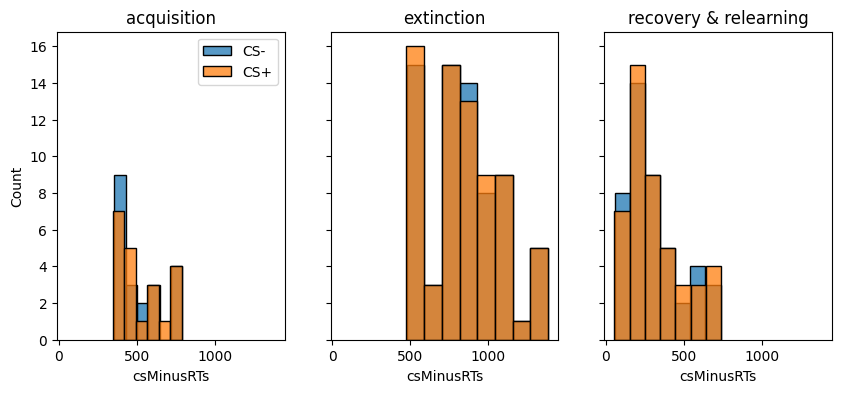

In [370]:
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
ax[0].set_title('acquisition')
sns.histplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'], x='csMinusRTs', ax=ax[0], label='CS-')#, hue='phase')
sns.histplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'], x='csPlusRTs', ax=ax[0], label='CS+')#, hue='phase')

ax[1].set_title('extinction')

sns.histplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'], x='csMinusRTs', ax=ax[1])#, hue='phase')
sns.histplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'], x='csPlusRTs', ax=ax[1])#, hue='phase')

ax[2].set_title('recovery & relearning')

sns.histplot(data = REC_DATA_TO_PLOT, x='csMinusRTs', ax=ax[2])#, hue='phase')
sns.histplot(data = REC_DATA_TO_PLOT, x='csPlusRTs', ax=ax[2])#, hue='phase')

ax[0].legend()



(0.0, 7000.0)

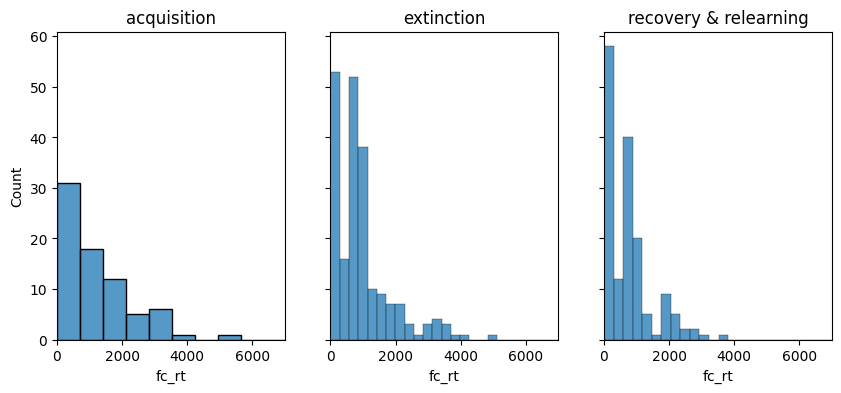

In [371]:
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
ax[0].set_title('acquisition')
sns.histplot(data = DATA_ACQEXT[DATA_ACQEXT.phase=='acquisition'], x='fc_rt', ax=ax[0])#, hue='phase')

ax[1].set_title('extinction')

sns.histplot(data = DATA_ACQEXT[DATA_ACQEXT.phase=='extinction'], x='fc_rt', ax=ax[1])#, hue='phase')

ax[2].set_title('recovery & relearning')

sns.histplot(data = DATA_REC, x='fc_rt', ax=ax[2])#, hue='phase')


ax[0].set_xlim(0,7000)
ax[1].set_xlim(0,7000)
ax[2].set_xlim(0,7000)



In [380]:
DATA_REC['n_responses_plus'] = DATA_REC.csPlusResponses.map(lambda x: len(x) if type(x)==type([]) else np.nan)
DATA_REC['n_responses_minus'] = DATA_REC.csMinusResponses.map(lambda x: len(x) if type(x)==type([]) else np.nan)

In [381]:
DATA_ACQEXT['n_responses_plus'] = DATA_ACQEXT.csPlusResponses.map(lambda x: len(x) if type(x)==type([]) else np.nan)
DATA_ACQEXT['n_responses_minus'] = DATA_ACQEXT.csMinusResponses.map(lambda x: len(x) if type(x)==type([]) else np.nan)

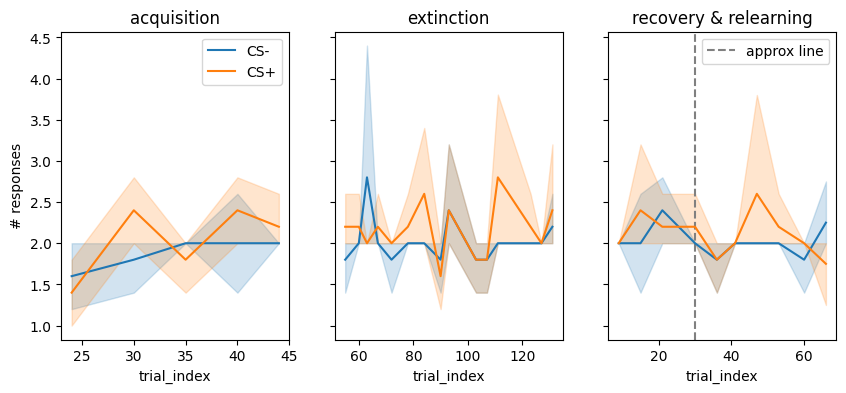

In [383]:
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey=True)
ax[0].set_title('acquisition')
sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'],x='trial_index',y='n_responses_minus', ax=ax[0], label='CS-')#, hue='phase')
sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='acquisition'],x='trial_index',y='n_responses_plus', ax=ax[0], label='CS+')#, hue='phase')

ax[1].set_title('extinction')

sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'],x='trial_index',y='n_responses_minus', ax=ax[1])#, hue='phase')
sns.lineplot(data = ACQ_DATA_TO_PLOT[ACQ_DATA_TO_PLOT.phase=='extinction'],x='trial_index',y='n_responses_plus', ax=ax[1])#, hue='phase')

ax[2].set_title('recovery & relearning')
ax[2].axvline(x=30, linestyle='--', color='grey', label='approx line')

sns.lineplot(data = REC_DATA_TO_PLOT,x='trial_index',y='n_responses_minus', ax=ax[2])#, hue='phase')
sns.lineplot(data = REC_DATA_TO_PLOT,x='trial_index',y='n_responses_plus', ax=ax[2])#, hue='phase')

ax[0].set_ylabel('# responses')
ax[0].legend()



In [386]:
JSON[40]

{'sequence': ['CS+', 'CS-'],
 'csPlusRating': '10',
 'csMinusRating': '74',
 'totalTime': 8746,
 'csPlusResponses': [72, '10'],
 'csPlusRTs': [609638.6999998093],
 'csMinusResponses': [5, '72', '74'],
 'csMinusRTs': [604846.6999998093, 607150.7999999523],
 'timeout': 0,
 'trial_type': 'expectancy-rating',
 'trial_index': 40,
 'time_elapsed': 608971,
 'internal_node_id': '0.0-36.0',
 'task': 'scream_acq_ext',
 'task_version': '0.1.H',
 'sub': 101,
 'timestamp': '202352181738',
 'fout': 's101_scream_acq_ext_202352181738'}

100%|██████████| 5/5 [00:00<00:00, 92.47it/s]


100%|██████████| 5/5 [00:00<00:00, 168.74it/s]
